# Comparison of pixelwise and reslicing-based temporal autocorrelation analysis

In the following, we present implementations of two possible approaches to obtaining the global oscillation period from a given image stack containing data on Min protein surface patterns.<br>
These two approaches (referred to as "pixelwise" and "reslicing" methods) will be compared with respect to their results and computational efficiency.

## Preparation
Import of required modules and packages.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import time as time

from numpy import conj, real
from numpy.fft import fft, ifft

from min_analysis_tools import correlation_tools
from min_analysis_tools.correlation_tools import fit_analyze_peaks


from cmath import nan

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

plt.rc("font", size=10)  # controls default text size
plt.rcParams.update({"font.family": "arial"})

## Selection

Select input file path:

In [2]:
stack_path = Path().cwd() / "example_data" / "paper_example.tif"

Select temporal autocorrelation analysis parameters:

In [3]:
reps_per_kymostack = 10  # pick ... kymographs around middle
kymoband = 0.8  # analyse middle ... part of image

In [4]:
# Load stack
Min_st = io.imread(stack_path)
stackname = stack_path.stem
nt, ny, nx = np.shape(Min_st)

slices2analyze_x = ny * np.linspace(
    0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
)
slices2analyze_x = slices2analyze_x.astype(int)

slices2analyze_y = nx * np.linspace(
    0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
)
slices2analyze_y = slices2analyze_y.astype(int)

Current reps_per_kymostack: 10
Current kymoband: 0.8
Current file: paper_example, size: 512 pixels x 512 pixels x 20 frames


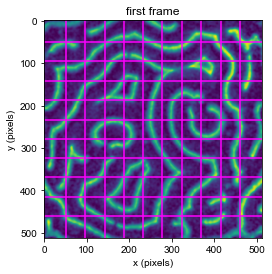

In [5]:
print(f"Current reps_per_kymostack: {reps_per_kymostack}")
print(f"Current kymoband: {kymoband}")
print(f"Current file: {stackname}, size: {nx} pixels x {ny} pixels x {nt} frames")

fig, ax = plt.subplots(1, 1)
ax.imshow(Min_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title("first frame")
for y_axis in slices2analyze_x:
    ax.axhline(y=y_axis, color="magenta")
for x_axis in slices2analyze_y:
    ax.axvline(x=x_axis, color="magenta")

In the following, autocorrelation analysis will be performed on all points along the magenta lines. This will be done using both the reslicing method (as described in the main text of the paper as well as in the supplementary notebook *DEMO_MinDE_global_analysis.ipynb*), using one-dimensional autocorrelation analysis on linwise-averaged traces, and using pointwise one-dimensional autocorrelation anaylsis for every pixel along these lines.

## Reslicing method
This method fully relies on the tools provided within the *min_analysis_tools* package to perform 2D autocorrelation of $ty$- and $tx$-resliced frames. We perform peak analysis for the averaged autocorrelation trace from every selected slice, then average the results.

In [6]:
time_start = time.perf_counter()

## Reslice image stack
Min_shift_tx = np.moveaxis(Min_st, 0, -1)  # creates t-x resliced frames
Min_shift_yt = np.moveaxis(Min_st, -1, 0)  # creates y-t resliced frames
ff, rr, cc = np.shape(Min_shift_yt)
Min_shift_ty = np.empty((ff, cc, rr))
for frame in range(ff):  # transpose images to create t-y resliced frames
    Min_shift_ty[frame, :, :] = np.transpose(Min_shift_yt[frame, :, :])

## Perform analysis for t-x slices (fixed y)
(
    crmx_storage_x,
    slices2analyze_x,
) = correlation_tools.get_temporal_correlation_matrixes(
    Min_shift_tx,
    "x",
    kymoband,
    reps_per_kymostack,
    demo=False,
)

# Analyse selected traces with respect to first min and max
(
    first_min_pos_x,
    first_min_val_x,
    first_max_pos_x,
    first_max_val_x,
) = correlation_tools.analyze_temporal_profiles(
    "x", crmx_storage_x, slices2analyze_x, demo=False
)

## Perform analysis for t-y slices (fixed x)
(
    crmx_storage_y,
    slices2analyze_y,
) = correlation_tools.get_temporal_correlation_matrixes(
    Min_shift_ty,
    "y",
    kymoband,
    reps_per_kymostack,
    demo=False,
)

# Analyse selected traces with respect to first min and max
(
    first_min_pos_y,
    first_min_val_y,
    first_max_pos_y,
    first_max_val_y,
) = correlation_tools.analyze_temporal_profiles(
    "y", crmx_storage_y, slices2analyze_y, demo=False
)
time_elapsed_reslicing = time.perf_counter() - time_start

all_minima = np.append(first_min_pos_x, first_min_pos_y)
all_maxima = np.append(first_max_pos_x, first_max_pos_y)

mean_min_reslicing = np.nanmean(all_minima)
std_min_reslicing = np.nanstd(all_minima)
mean_max_reslicing = np.nanmean(all_maxima)
std_max_reslicing = np.nanstd(all_maxima)

Analyzing t-x slices for y = [ 51  96 142 187 233 278 324 369 415 460]
Analyzing t-y slices for x = [ 51  96 142 187 233 278 324 369 415 460]


## Pixelwise method
The pixelwise method relies on one-dimensional autocorrelation performed at individual pixel locations. It uses the peak-detection method for an autocorrelation trace provided in the package, but has otherwise been implemented separately as shown below. We finally average the results obtained from peak-analysis for all selected pixel positions.

In [7]:
def autocorrelate1d(fluorescence_trace):
    mean = np.mean(fluorescence_trace)
    var = np.var(fluorescence_trace)
    length = len(fluorescence_trace)
    trace = fluorescence_trace - mean
    autocorr_trace = real(ifft(fft(trace) * conj(fft(trace)))) / var / length
    try:
        (
            first_min_pos,
            first_min_val,
            first_max_pos,
            first_max_val,
        ) = fit_analyze_peaks(autocorr_trace, demo=False, title_demo=None)
    except:
        first_min_pos = nan
        first_min_val = nan
        first_max_pos = nan
        first_max_val = nan
    return first_min_pos, first_max_pos

In [8]:
all_maxima_collect = []
all_minima_collect = []

time_start = time.perf_counter()

for x in range(nx):
    for y in range(ny):
        if x in slices2analyze_y or y in slices2analyze_x:
            fluorescence_trace = Min_st[:, y, x]
            first_min_pos, first_max_pos = autocorrelate1d(fluorescence_trace)
            all_maxima_collect.append(first_max_pos)
            all_minima_collect.append(first_min_pos)

time_elapsed_pixelwise = time.perf_counter() - time_start

all_minima = np.array(all_minima_collect)
all_maxima = np.array(all_maxima_collect)

mean_min_pixelwise = np.nanmean(all_minima)
std_min_pixelwise = np.nanstd(all_minima)
mean_max_pixelwise = np.nanmean(all_maxima)
std_max_pixelwise = np.nanstd(all_maxima)

## Results

### Reslicing method:

In [9]:
print(f"first valley: {mean_min_reslicing:.02f} ± {std_min_reslicing:.02f} frames")
print(
    f"first peak (oscillation period): {mean_max_reslicing:.02f} ± {std_max_reslicing:.02f} frames"
)
print(f"elapsed computation time: {time_elapsed_reslicing:.04f} s")

first valley: 2.30 ± 0.14 frames
first peak (oscillation period): 4.39 ± 0.18 frames
elapsed computation time: 0.1987 s


### Pixelwise method:

In [10]:
print(f"first valley: {mean_min_pixelwise:.02f} ± {std_min_pixelwise:.02f} frames")
print(
    f"first peak (oscillation period): {mean_max_pixelwise:.02f} ± {std_max_pixelwise:.02f} frames"
)
print(f"elapsed computation time: {time_elapsed_pixelwise:.04f} s")

first valley: 2.28 ± 0.30 frames
first peak (oscillation period): 4.44 ± 0.40 frames
elapsed computation time: 70.5601 s
